<a href="https://colab.research.google.com/github/Hamid-Mofidi/PINNs/blob/main/Poisson1D_Dirichlet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Laplace operator:  $$Δu = u_{xx} + u_{yy}$$

# Harmonic functions: $$ Δ u = 0$$

# Poisson equation: $$ Δ u = f(x)$$

# Let's solve the following Poisson equation:  $$Δu = -π^2 \sin(πx) $$

Boundary conditions: $u(-1) = u(1) = 0$

# The exact solution is : $$ u(x) = \sin(π x)$$

In [1]:
 ! pip install pyDOE

  Preparing metadata (setup.py) ... done
  Created wheel for pyDOE: filename=pyDOE-0.3.8-py3-none-any.whl size=18168 sha256=c61bbcd8163a3d5e79a1c2422811ac0d2297585c30bd668788ad856fea9cb061
  Stored in directory: /root/.cache/pip/wheels/ce/b6/d7/c6b64746dba6433c593e471e0ac3acf4f36040456d1d160d17
Successfully built pyDOE


In [2]:
import torch
import torch.autograd as autograd         # computation graph
from torch import Tensor                  # tensor node in the computation graph
import torch.nn as nn                     # neural networks
import torch.optim as optim               # optimizers e.g. gradient descent, ADAM, etc.

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.ticker
from sklearn.model_selection import train_test_split

import numpy as np
import time
from pyDOE import lhs         #Latin Hypercube Sampling
import scipy.io

#Set default dtype to float32
torch.set_default_dtype(torch.float)

#PyTorch random number generator
torch.manual_seed(1234)

# Random number generators in other libraries
np.random.seed(1234)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(device)

if device == 'cuda':
    print(torch.cuda.get_device_name())

cpu


# Tunning Parameters


In [3]:
steps=5000
lr=1e-3
layers = np.array([1,50,50,20,50,50,1]) #5 hidden layers
# To generate new data:
min=-1
max=1
total_points=500
#Nu: Number of training points (2 as we onlt have 2 boundaries), # Nf: Number of collocation points (Evaluate PDE)
Nu=2
Nf=250

# Functions

In [4]:
def f_BC(x):
  return 1-torch.abs(x)
def f_real(x):
  return torch.sin(np.pi*x)
def PDE(x):
  return -1*(np.pi**2)*torch.sin(np.pi*x)

# Neural Network:

In [5]:
class FCN(nn.Module):
    ##Neural Network
    def __init__(self,layers):
        super().__init__() #call __init__ from parent class
        'activation function'
        self.activation = nn.Tanh()
        'loss function'
        self.loss_function = nn.MSELoss(reduction ='mean')
        'Initialise neural network as a list using nn.Modulelist'
        self.linears = nn.ModuleList([nn.Linear(layers[i], layers[i+1]) for i in range(len(layers)-1)])
        self.iter = 0
        'Xavier Normal Initialization'
        # std = gain * sqrt(2/(input_dim+output_dim))
        for i in range(len(layers)-1):

            # weights from a normal distribution with
            # Recommended gain value for tanh = 5/3?
            nn.init.xavier_normal_(self.linears[i].weight.data, gain=1.0)

            # set biases to zero
            nn.init.zeros_(self.linears[i].bias.data)
    'foward pass'
    def forward(self,x):
        if torch.is_tensor(x) != True:
            x = torch.from_numpy(x)
        a = x.float()
        for i in range(len(layers)-2):
            z = self.linears[i](a)
            a = self.activation(z)
        a = self.linears[-1](a)
        return a
    'Loss Functions'
    #Loss BC

    def lossBC(self,x_BC,y_BC):
      loss_BC=self.loss_function(self.forward(x_BC),y_BC)
      return loss_BC
    #Loss PDE
    def lossPDE(self,x_PDE):
      g=x_PDE.clone()
      g.requires_grad=True #Enable differentiation
      f=self.forward(g)
      f_x=autograd.grad(f,g,torch.ones([x_PDE.shape[0],1]).to(device),retain_graph=True, create_graph=True)[0] #first derivative
      f_xx=autograd.grad(f_x,g,torch.ones([x_PDE.shape[0],1]).to(device), create_graph=True)[0]#second derivative
      return self.loss_function(f_xx,PDE(g))

    def loss(self,x_BC,y_BC,x_PDE):
      loss_bc=self.lossBC(x_BC,y_BC)
      loss_pde=self.lossPDE(x_PDE)
      return loss_bc+loss_pde

# Generate data

In [6]:

# get the analytical solution over the full domain
x = torch.linspace(min,max,total_points).view(-1,1) #prepare to NN
y = f_real(x)
print(x.shape, y.shape)

torch.Size([500, 1]) torch.Size([500, 1])


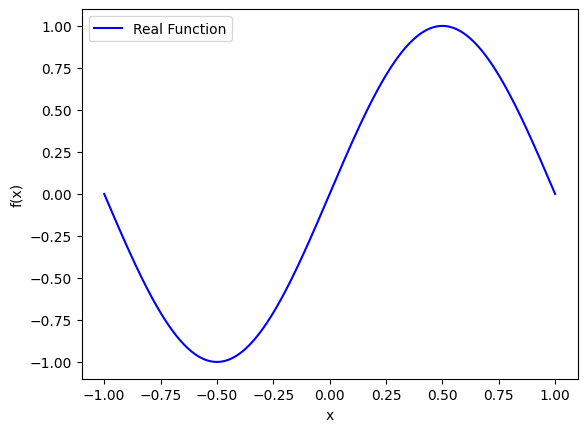

In [7]:

fig, ax1 = plt.subplots()
ax1.plot(x.detach().numpy(),y.detach().numpy(),color='blue',label='Real Function')
#ax1.plot(x_train.detach().numpy(),yh.detach().numpy(),color='red',label='Pred_Train')
ax1.set_xlabel('x',color='black')
ax1.set_ylabel('f(x)',color='black')
ax1.tick_params(axis='y', color='black')
ax1.legend(loc = 'upper left')

In [8]:
#def get_training_data(x):
#Nu: Number of training point, # Nf: Number of colloction points
# Set Boundary conditions x=min & x= max
BC_1=x[0,:]
BC_2=x[-1,:]
# Total Tpaining points BC1+BC2
all_train=torch.vstack([BC_1,BC_2])
#Select Nu points
idx = np.random.choice(all_train.shape[0], Nu, replace=False)
x_BC=all_train[idx]
#Select Nf points
# Latin Hypercube sampling for collocation points
x_PDE = BC_1 + (BC_2-BC_1)*lhs(1,Nf)
x_PDE = torch.vstack((x_PDE,x_BC))

In [9]:
y_BC=f_BC(x_BC).to(device)

# Train Neural Network

In [10]:
#Store tensors to GPU
torch.manual_seed(123)
x_PDE=x_PDE.float().to(device)
x_BC=x_BC.to(device)
#Create Model
model = FCN(layers)
print(model)
model.to(device)
params = list(model.parameters())
optimizer = torch.optim.Adam(model.parameters(),lr=lr,amsgrad=False)
start_time = time.time()

FCN(
  (activation): Tanh()
  (loss_function): MSELoss()
  (linears): ModuleList(
    (0): Linear(in_features=1, out_features=50, bias=True)
    (1): Linear(in_features=50, out_features=50, bias=True)
    (2): Linear(in_features=50, out_features=20, bias=True)
    (3): Linear(in_features=20, out_features=50, bias=True)
    (4): Linear(in_features=50, out_features=50, bias=True)
    (5): Linear(in_features=50, out_features=1, bias=True)
  )
)


In [11]:
model.lossBC(x_BC,y_BC)

tensor(0.0160, grad_fn=<MseLossBackward0>)

In [12]:
for i in range(steps):
    yh = model(x_PDE)
    loss = model.loss(x_BC,y_BC,x_PDE)# use mean squared error
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if i%(steps/10)==0:
      print(loss)

tensor(47.8740, grad_fn=<AddBackward0>)
tensor(0.0155, grad_fn=<AddBackward0>)
tensor(0.0031, grad_fn=<AddBackward0>)
tensor(0.0112, grad_fn=<AddBackward0>)
tensor(0.0007, grad_fn=<AddBackward0>)
tensor(0.0006, grad_fn=<AddBackward0>)
tensor(0.0002, grad_fn=<AddBackward0>)
tensor(0.0002, grad_fn=<AddBackward0>)
tensor(0.0002, grad_fn=<AddBackward0>)
tensor(9.8674e-05, grad_fn=<AddBackward0>)


# Plots:

In [13]:
# Function
yh=model(x.to(device))
y=f_real(x)
#Error
print(model.lossBC(x.to(device),f_real(x).to(device)))

tensor(0.0001, grad_fn=<MseLossBackward0>)


In [14]:
# Derivative
g=x.to(device)
g=g.clone()
g.requires_grad=True #Enable differentiation
f=model(g)
f_x=autograd.grad(f,g,torch.ones([g.shape[0],1]).to(device),retain_graph=True, create_graph=True)[0]

In [15]:
# Detach from GPU
y_plot=y.detach().numpy()
yh_plot=yh.detach().cpu().numpy()
f_x_plot=f_x.detach().cpu().numpy()

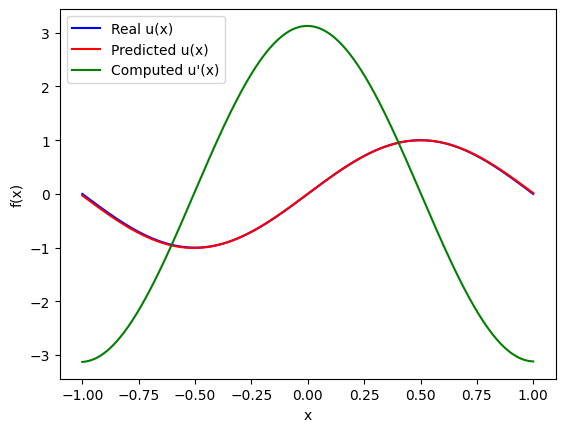

In [16]:
# Plot
fig, ax1 = plt.subplots()
ax1.plot(x,y_plot,color='blue',label='Real u(x)')
ax1.plot(x,yh_plot,color='red',label='Predicted u(x)')
ax1.plot(x,f_x_plot,color='green',label='Computed u\'(x)')
ax1.set_xlabel('x',color='black')
ax1.set_ylabel('f(x)',color='black')
ax1.tick_params(axis='y', color='black')
ax1.legend(loc = 'upper left')